In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from data_generator import DataGenerator
from sklearn.utils import shuffle
import numpy as np
import cv2
from keras.utils import Sequence
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import keras
import nibabel as nib
from PIL import Image
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
from keras.layers import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import os
from keras.layers import Input

In [2]:
training_generator = DataGenerator()

In [3]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
    X = Conv2D(num_filters,kernel_size=(kernel_size,kernel_size),strides=(1,1),padding='same' , kernel_initializer = 'he_normal')(input_mat)
    if batch_norm:
        X = BatchNormalization()(X)
 
    X = Activation('relu')(X)

    X = Conv2D(num_filters,kernel_size=(kernel_size,kernel_size),strides=(1,1),padding='same' , kernel_initializer = 'he_normal')(X)
    if batch_norm:
        X = BatchNormalization()(X)
 
    X = Activation('relu')(X)
   
    #X = add([X,Y])
 
    return X

In [4]:
def Unet(input_img, n_filters = 32, dropout = 0.4, batch_norm = True):

  c1 = conv_block(input_img,n_filters,3,batch_norm)
  p1 = Conv2D(n_filters,kernel_size = (3,3), strides=2, padding = 'same' , kernel_initializer = 'he_normal')(c1)
  #p1 = Dropout(dropout)(p1)
 
  c2 = conv_block(p1,n_filters*2,3,batch_norm);
  p2 = Conv2D(n_filters,kernel_size = (3,3), strides=2 , padding = 'same' , kernel_initializer = 'he_normal')(c2)
  #p2 = Dropout(dropout)(p2)

  c3 = conv_block(p2,n_filters*4,3,batch_norm);
  p3 = Conv2D(n_filters,kernel_size = (3,3), strides=2 , padding = 'same' , kernel_initializer = 'he_normal')(c3)
  #p3 = Dropout(dropout)(p3)
 
  c4 = conv_block(p3,n_filters*8,3,batch_norm);
  p4 = Conv2D(n_filters,kernel_size = (3,3), strides=2 , padding = 'same' , kernel_initializer = 'he_normal')(c4)
  #p4 = Dropout(dropout)(p4)
 
  c5 = conv_block(p4,n_filters*16,3,batch_norm);

  u6 = Conv2DTranspose(n_filters*8, (3,3), strides=(2, 2), padding='same')(c5);
  u6 = concatenate([u6,c4]);
  c6 = conv_block(u6,n_filters*8,3,batch_norm)
  #c6 = Dropout(dropout)(c6)
  u7 = Conv2DTranspose(n_filters*4,(3,3),strides = (2,2) , padding= 'same')(c6);

  u7 = concatenate([u7,c3]);
  c7 = conv_block(u7,n_filters*4,3,batch_norm)
  #c7 = Dropout(dropout)(c7)
  u8 = Conv2DTranspose(n_filters*2,(3,3),strides = (2,2) , padding='same')(c7);
  u8 = concatenate([u8,c2]);

  c8 = conv_block(u8,n_filters*2,3,batch_norm)
  #c8 = Dropout(dropout)(c8)
  u9 = Conv2DTranspose(n_filters,(3,3),strides = (2,2) , padding='same')(c8);

  u9 = concatenate([u9,c1]);

  c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = Model(inputs=input_img, outputs=outputs)

  return model

In [5]:
def dice_coef_2(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
input_img = Input((240, 240, 4))
model = Unet(input_img,32,0.4,True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 240, 240, 32)         1184      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 240, 240, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 240, 240, 32)         0         ['batch_normalization[0][0

                                                                                                  
 conv2d_13 (Conv2D)          (None, 15, 15, 512)          2359808   ['activation_8[0][0]']        
                                                                                                  
 batch_normalization_9 (Bat  (None, 15, 15, 512)          2048      ['conv2d_13[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_9 (Activation)   (None, 15, 15, 512)          0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 30, 30, 256)          1179904   ['activation_9[0][0]']        
 anspose) 

 batch_normalization_16 (Ba  (None, 240, 240, 32)         128       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 240, 240, 32)         0         ['batch_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 240, 240, 32)         9248      ['activation_16[0][0]']       
                                                                                                  
 batch_normalization_17 (Ba  (None, 240, 240, 32)         128       ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
          

In [7]:
learning_rate = 0.00015
decay_rate = 0.0000001


model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate,decay = decay_rate),loss='binary_crossentropy', metrics=[dice_coef_2])


In [9]:
os.makedirs('/working/', exist_ok=True)

In [ ]:
history = model.fit_generator(generator=training_generator,epochs = 50 , use_multiprocessing=True,workers=11,steps_per_epoch = 60)
model.save("data_Gen.h5")


Epoch 1/50
60/60 [==============================] - 941s 15s/step - loss: -0.2687 - dice_coef_2: 0.2994
Epoch 2/50
60/60 [==============================] - 938s 15s/step - loss: -1.0158 - dice_coef_2: 0.3796
Epoch 3/50
60/60 [==============================] - 942s 15s/step - loss: -1.2091 - dice_coef_2: 0.4102
Epoch 4/50
60/60 [==============================] - 939s 15s/step - loss: -1.3648 - dice
Epoch 5/50
60/60 [==============================] - 936s 15s/step - loss: -1.5068 - dice
Epoch 6/50
60/60 [==============================] - 934s 15s/step - loss: -1.6270 - dice_coef_2: 0.5593
Epoch 7/50
60/60 [==============================] - 937s 15s/step - loss: -1.7390 - dice_coef_2: 0.5848
8/50
60/60 [==============================] - 938s 15s/step - loss: -1.8421 - dice_coef_2: 0.6103
Epoch 9/50
60/60 [==============================] - 932s 15s/step - loss: -1.9281 - dice_coef_2: 0.6278
Epoch 10/50
60/60 [==============================] - 926s 15s/step - loss: -2.0594 - dice_coef_2: 0.6646
Epoch 11/50
60/60 [==============================] - 934s 15s/step - loss: -2.1563 - dice_coef_2: 0.6863
Epoch 12/50
60/60 [==============================] - 936s 15s/step - loss: -2.2736 - dice_coef_2: 0.7127
Epoch 13/50
60/60 [==============================] - 941s 15s/step - loss: -2.3652 - dice_coef_2: 0.7292
Epoch 14/50
60/60 [==============================] - 938s 15s/step - loss: -2.4996 - dice_coef_2: 0.7586
Epoch 15/50
60/60 [==============================] - 941s 15s/step - loss: -2.5961 - dice_coef_2: 0.7787
Epoch 16/50
60/60 [==============================] - 939s 15s/step - loss: -2.7248 - dice_coef_2: 0.8038
Epoch 17/50
60/60 [==============================] - 934s 15s/step - loss: -2.8326 - dice_coef_2: 0.8237
Epoch 18/50
60/60 [==============================] - 941s 15s/step - loss: -2.9343 - dice_coef_2: 0.8367
Epoch 19/50
60/60 [==============================] - 934s 15s/step - loss: -3.0540 - dice_coef_2: 0.8570
Epoch 20/50
60/60 [==============================] - 935s 15s/step - loss: -3.2048 - dice_coef_2: 0.8859
Epoch 21/50
60/60 [==============================] - 932s 15s/step - loss: -3.2965 - dice_coef_2: 0.8976
Epoch 22/50
60/60 [==============================] - 952s 15s/step - loss: -3.4325 - dice_coef_2: 0.9142
Epoch 23/50
60/60 [==============================] - 959s 15s/step - loss: -3.5470 - dice_coef_2: 0.9361
Epoch 24/50
60/60 [==============================] - 934s 15s/step - loss: -3.6702 - dice_coef_2: 0.9463
Epoch 25/50
60/60 [==============================] - 932s 15s/step - loss: -3.7833 - dice_coef_2: 0.9577
Epoch 26/50
60/60 [==============================] - 934s 15s/step - loss: -3.9134 - dice_coef_2: 0.9742
Epoch 27/50
60/60 [==============================] - 937s 15s/step - loss: -4.0400 - dice_coef_2: 0.9894
Epoch 28/50
60/60 [==============================] - 943s 15s/step - loss: -4.1678 - dice_coef_2: 1.0022
Epoch 29/50
60/60 [==============================] - 940s 15s/step - loss: -4.2953 - dice_coef_2: 1.0134
Epoch 30/50
60/60 [==============================] - 933s 15s/step - loss: -4.4318 - dice_coef_2: 1.0276
Epoch 31/50
60/60 [==============================] - 933s 15s/step - loss: -4.5533 - dice_coef_2: 1.0322
Epoch 32/50
60/60 [==============================] - 932s 15s/step - loss: -4.6871 - dice_coef_2: 1.0364
Epoch 33/50
60/60 [==============================] - 932s 15s/step - loss: -4.8281 - dice_coef_2: 1.0431
Epoch 34/50
60/60 [==============================] - 973s 16s/step - loss: -4.9261 - dice_coef_2: 1.0426
Epoch 35/50
60/60 [==============================] - 984s 16s/step - loss: -5.0983 - dice_coef_2: 1.0516
Epoch 36/50
60/60 [==============================] - 967s 15s/step - loss: -5.2393 - dice_coef_2: 1.0565
Epoch 37/50
60/60 [==============================] - 954s 15s/step - loss: -5.3535 - dice_coef_2: 1.0544
Epoch 38/50
60/60 [==============================] - 941s 15s/step - loss: -5.4889 - dice_coef_2: 1.0575
Epoch 39/50
60/60 [==============================] - 946s 15s/step - loss: -5.6516 - dice_coef_2: 1.0569
Epoch 40/50
60/60 [==============================] - 936s 15s/step - loss: -5.7173 - dice_coef_2: 1.0418
Epoch 41/50
60/60 [==============================] - 943s 15s/step - loss: -5.8972 - dice_coef_2: 1.0587
Epoch 42/50
60/60 [==============================] - 939s 15s/step - loss: -6.0364 - dice_coef_2: 1.0556
Epoch 43/50
60/60 [==============================] - 933s 15s/step - loss: -6.1967 - dice_coef_2: 1.0598
Epoch 44/50
60/60 [==============================] - 944s 15s/step - loss: -6.3384 - dice_coef_2: 1.0543
Epoch 45/50
60/60 [==============================] - 943s 15s/step - loss: -6.4973 - dice_coef_2: 1.0610
Epoch 46/50
60/60 [==============================] - 945s 15s/step - loss: -6.6384 - dice_coef_2: 1.0534
Epoch 47/50
60/60 [==============================] - 938s 15s/step - loss: -6.8185 - dice_coef_2: 1.0646
Epoch 48/50
60/60 [==============================] - 933s 15s/step - loss: -6.9356 - dice_coef_2: 1.0552
Epoch 49/50
60/60 [==============================] - 930s 15s/step - loss: -7.1048 - dice_coef_2: 1.0553
Epoch 50/50
60/60 [==============================] - 932s 15s/step - loss: -7.2632 - dice_coef_2: 1.0600

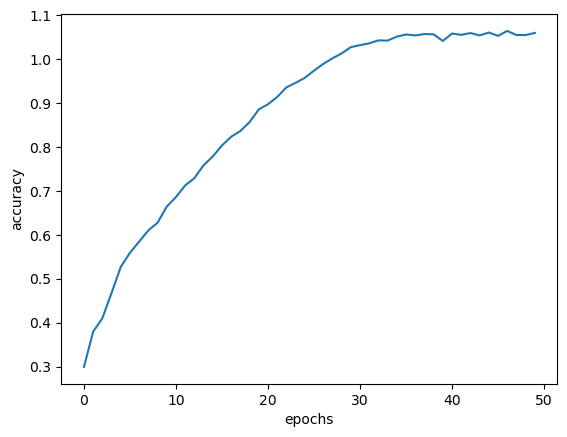

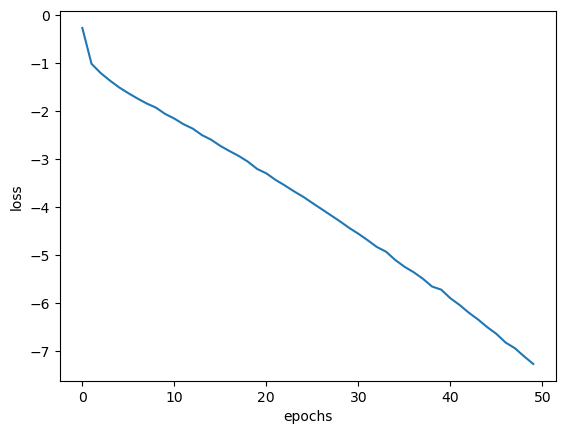

In [10]:
plt.plot(history.history['dice_coef_2'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('../working/accuracy_plot1')
plt.show()
plt.close()

plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('../working/loss_plot1')
plt.show()
plt.close()